# Titanic Revisited (w/ XGBoost)

### Goal
I originally worked with this dataset about 3.5 years ago when working through Udacity's Nanodegree in Data Analytics. I has, more or less, no idea what I was doing then. I thought it would be nice to revisit this dataset and see if I could get a better accuracy than my first time through (which was around 74% if I recall). Particularly, I've been wanting to work with XGBoost for awhile and this seems an appropriate classification problem to give it a go on!

In [125]:

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/gender_submission.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Generation and Removal

Time to generate a few features which may be of use in classification.

In [126]:
#Does the passanger have a cabin?
train['cabin_binary'] = train["Cabin"].apply(lambda i: 0 if str(i) == "nan" else 1)

#Family Size
train['family_size'] = 1 + train['SibSp'] + train['Parch']

#Fix Nulls
train['Embarked'] = train['Embarked'].fillna('S')

#A few age specific Binaries
train['Child'] = train["Age"].apply(lambda i: 1 if i <= 17 and i > 6 else 0)
train['toddler'] = train["Age"].apply(lambda i: 1 if i <= 6 else 0)
train['Elderly'] = train["Age"].apply(lambda i: 1 if i >= 60 else 0)

#No requirement to standardize in DT models, but might as well
fare_scaler = StandardScaler()
fare_scaler.fit(train['Fare'].values.reshape(-1, 1))
train['fare_std'] = fare_scaler.transform(train['Fare'].values.reshape(-1, 1))

#get status of passanger
train['title'] = 'default'

for i in train.values:
    name = i[3] #First checks for rare titles (Thanks Anisotropic's wonderful Kernel for inspiration//help here!)
    for e in ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        if e in name:
            train.loc[train['Name'] == name, 'title'] = 'rare'
    if 'Miss' in name or  'Mlle' in name or 'Ms' in name or 'Mme' in name or 'Mrs' in name:
        train.loc[train['Name'] == name, 'title'] = 'Ms'
    if 'Mr.' in name or 'Master' in name:
        train.loc[train['Name'] == name, 'title'] = 'Mr'


train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_binary,family_size,Child,toddler,Elderly,fare_std,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0,0,0,-0.502445,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,0,0,0.786845,Ms
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,-0.488854,Ms
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,0,0,0.420730,Ms
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,0,-0.486337,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,1,0,0,0,-0.478116,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1,0,0,0,0.395814,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,5,0,1,0,-0.224083,Mr
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,3,0,0,0,-0.424256,Ms
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0,2,1,0,0,-0.042956,Ms


Lets send the test data through the same pipeline!

In [127]:
#Does the passanger have a cabin?
test['cabin_binary'] = test["Cabin"].apply(lambda i: 0 if str(i) == "nan" else 1)

#Family Size
test['family_size'] = 1 + test['SibSp'] + test['Parch']

#Fix Nulls
test['Embarked'] = test['Embarked'].fillna('S')

#A few age specific Binaries
test['Child'] = test["Age"].apply(lambda i: 1 if i <= 17 and i > 6 else 0)
test['toddler'] = test["Age"].apply(lambda i: 1 if i <= 6 else 0)
test['Elderly'] = test["Age"].apply(lambda i: 1 if i >= 60 else 0)

#standardize
test['fare_std'] = fare_scaler.transform(test['Fare'].values.reshape(-1, 1))

#get status of passanger
test['title'] = 'default'

for i in test.values:
    name = i[2] #First checks for rare titles (Thanks Anisotropic's wonderful Kernel for inspiration//help here!)
    for e in ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        if e in name:
            test.loc[test['Name'] == name, 'title'] = 'rare'
    if 'Miss' in name or  'Mlle' in name or 'Ms' in name or 'Mme' in name or 'Mrs' in name:
        test.loc[test['Name'] == name, 'title'] = 'Ms'
    if 'Mr.' in name or 'Master' in name:
        test.loc[test['Name'] == name, 'title'] = 'Mr'


test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_binary,family_size,Child,toddler,Elderly,fare_std,title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,0,-0.490783,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,2,0,0,0,-0.507479,Ms
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,-0.453367,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1,0,0,0,-0.474005,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,3,0,0,0,-0.401017,Ms
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,1,1,0,0,-0.462679,Mr
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0,1,0,0,0,-0.494810,Ms
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,3,0,0,0,-0.064516,Mr
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0,1,0,0,0,-0.502864,Ms
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,3,0,0,0,-0.162169,Mr


Remove Unneccesary Features

In [128]:
#TEST BOTH FARE AND FARE_STD FOR BEST OPTION IN CLASSIFIER
train = train.drop(['Name','PassengerId', 'Ticket', 'Cabin', 'Fare', 'SibSp'], axis = 1)
test = test.drop(['Name','PassengerId', 'Ticket', 'Cabin', 'Fare', 'SibSp'], axis = 1)

train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,cabin_binary,family_size,Child,toddler,Elderly,fare_std,title
0,0,3,male,22.0,0,7.2500,S,0,2,0,0,0,-0.502445,Mr
1,1,1,female,38.0,0,71.2833,C,1,2,0,0,0,0.786845,Ms
2,1,3,female,26.0,0,7.9250,S,0,1,0,0,0,-0.488854,Ms
3,1,1,female,35.0,0,53.1000,S,1,2,0,0,0,0.420730,Ms
4,0,3,male,35.0,0,8.0500,S,0,1,0,0,0,-0.486337,Mr


## Quick EDA Visuals
Lets do just a little bit of EDA with Seaborn:

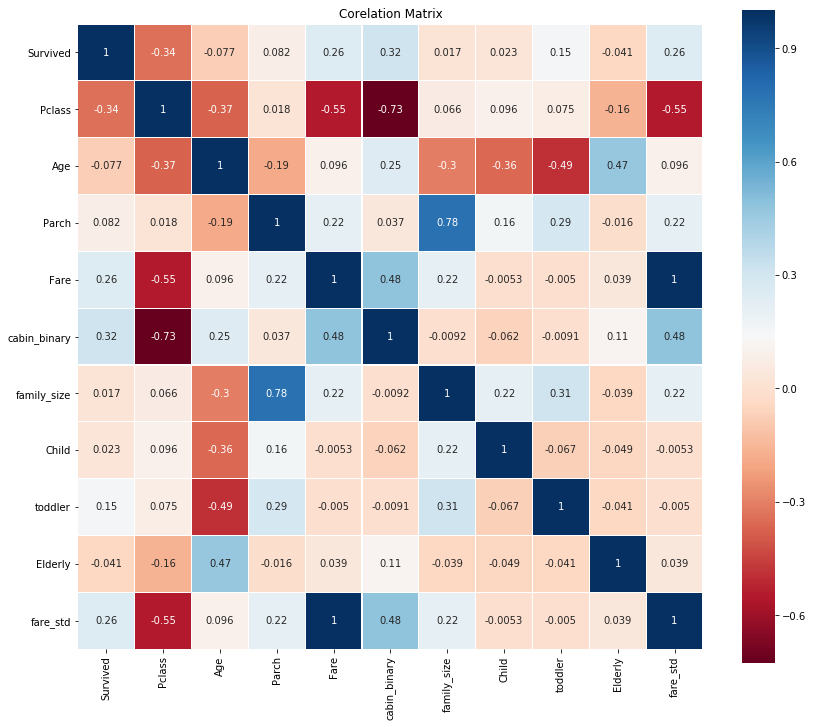

In [129]:
#COR MATRIX OF numerical vars
train_num_subset = train.drop(['title', 'Embarked', 'Sex'], axis = 1)
plt.figure(figsize=(14,12))
plt.title('Corelation Matrix', size=12)
sns.heatmap(train_num_subset.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


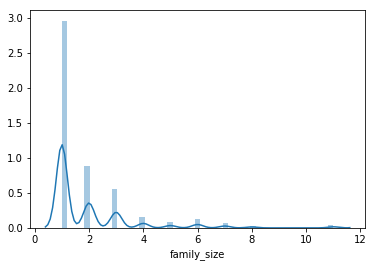

In [131]:
#Family size histo
sns.distplot(train['family_size'])

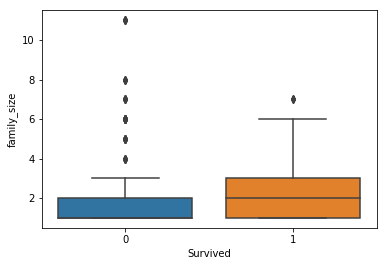

In [144]:
#boxplot of family size and survival
sns.boxplot("Survived", y="family_size", data = train)

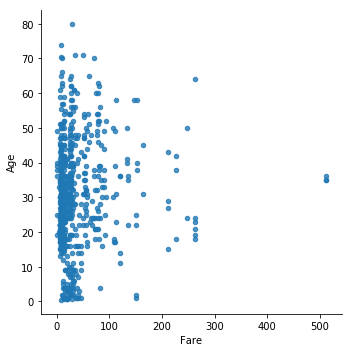

In [141]:
#Fare to Age relationship?
sns.lmplot('Fare', 'Age', data = train, 
           fit_reg=False,scatter_kws={"marker": "D", "s": 20}) 


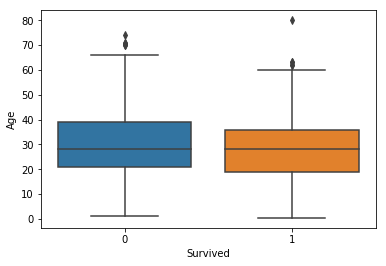

In [145]:
#boxplot of age and survival
sns.boxplot("Survived", "Age", data = train)

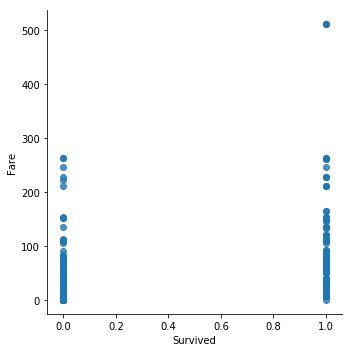

In [149]:
#bar chart of age and survival
sns.lmplot("Survived", "Fare", data = train, fit_reg=False)

## Classifing with XGBoost

I'll be testing it to AdaBoost, GradientBoost, RandomForest, andddd maybe a SVC or something else.